# Kaggle Categorical Feature Encoding Challenge II

In [227]:
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import train_test_split
from pandas.api.types import CategoricalDtype 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [228]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [229]:
def overview_table(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)
    return summary



Let's take an overview of the entire training set. From the output, it appears that for most of the columns, roughly 9% of values are missing. It's worth investigating further to get more information on these missing values

In [230]:
overview_table(train)

Dataset Shape: (600000, 25)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,600000,0,1,2,19.19
1,bin_0,float64,17894,2,0,1,0,0.44
2,bin_1,float64,18003,2,0,1,1,0.69
3,bin_2,float64,17930,2,0,0,0,0.85
4,bin_3,object,18014,2,F,F,F,0.95
5,bin_4,object,18047,2,N,Y,N,1.00
6,nom_0,object,18252,3,Red,Red,Red,1.31
7,nom_1,object,18156,6,Trapezoid,Star,NaN,2.27
8,nom_2,object,18035,6,Hamster,Axolotl,Hamster,2.27
9,nom_3,object,18121,6,Russia,NaN,Canada,2.27


## Null Value Analysis

It appears that the majority of the time there is either no null or one null on any given given row. This eliminates the possibility that there are many rows where many of the features are null at once. It appears very inconsistent. I would still like to look further at the null's by column and see their impact on the predictor before taking any action on them.

missing_vals = train.isnull().sum(axis=1)
plt.hist(missing_vals, normed=True, bins=30)
plt.ylabel('Probability');
plt.title('Number of Nulls in a Row')
plt.show()

In [231]:
#train[train['bin_0'].notna()]['target'].value_counts()/len(train[train['bin_0'].notna()])
sel_cols = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1','nom_2', 'nom_3', 'nom_4', 'nom_5', 
            'nom_6', 'nom_7', 'nom_8', 'nom_9','ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']
na_diff = []
col_diff = []
for col in sel_cols:
    col_diff.append(col)
    na_diff.append((train[train[col].notna()]['target'].value_counts()/len(train[train[col].notna()]))[0]-\
                   (train[train[col].isna()]['target'].value_counts()/len(train[train[col].isna()]))[0])

I want to now compare the null values against the non-nulls and see their impact for each feature against the predictor variable. It doesn't appear that any of the features having null values leads to a signficantly different result against the non-nulls. The most signficant deviation was day changing by 0.8% lower in the not-nas. This makes me more comfortable processing these na's without worrying about signficant impact

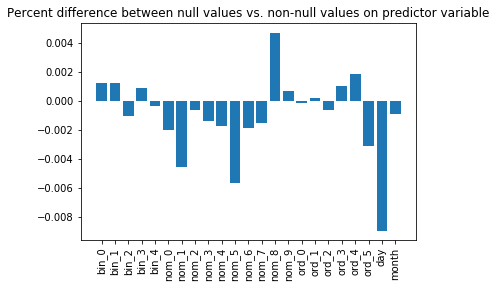

In [232]:
plt.bar(col_diff,na_diff)
plt.xticks(rotation='vertical')
plt.title("Percent difference between null values vs. non-null values on predictor variable")
plt.show()

## Feature Engineering

### Binary Features

For the binary features, I will change the missing values/na's to be -1, creating a category for themself as to not improperly weight the balance already existing in the feature.

In [233]:
#The first 3 bin features are already in numeric representation so I just need to apply fillna
train['bin_0'] = train['bin_0'].fillna(-1)
test['bin_0'] = test['bin_0'].fillna(-1)
train['bin_1'] = train['bin_1'].fillna(-1)
test['bin_1'] = test['bin_1'].fillna(-1)
train['bin_2'] = train['bin_2'].fillna(-1)
test['bin_2'] = test['bin_2'].fillna(-1)

In [234]:
repl = {'T' : 1, 'F' : 0, 'Y' : 1, 'N' : 0}
#map numeric values
train['bin_3'] = train['bin_3'].map(repl)
test['bin_3'] = test['bin_3'].map(repl)
train['bin_4'] = train['bin_4'].map(repl)
test['bin_4'] = test['bin_4'].map(repl)
#replace nas
train['bin_3'] = train['bin_3'].fillna(-1)
test['bin_3'] = test['bin_3'].fillna(-1)
train['bin_4'] = train['bin_4'].fillna(-1)
test['bin_4'] = test['bin_4'].fillna(-1)

### Low-Cardinality Nominal Features

In [235]:
#One hot encode nominal features
train = pd.get_dummies(train, columns=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],\
                          prefix=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],dummy_na=True,drop_first=True)
test = pd.get_dummies(test, columns=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],\
                          prefix=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],dummy_na=True,drop_first=True)

### High-Cardinality Nominal Features

In [236]:
high_card_nom = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']

for col in high_card_nom:
    train[f'hash_{col}'] = train[col].apply( lambda x: hash(str(x)) % 5000 )
    test[f'hash_{col}'] = test[col].apply( lambda x: hash(str(x)) % 5000 )
    train = train.drop([col], axis = 1)
    test = test.drop([col], axis = 1)

It appears that the hashed value of an NA is 3898 as can be seen from the histogram below. I will evaluate whether or not this should be imputed with the mean value or it should be left in this position

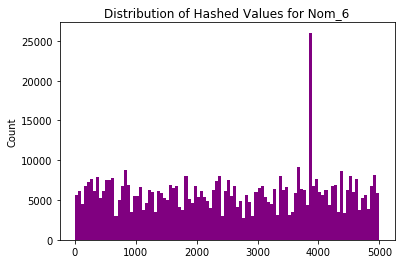

In [237]:
plt.hist(train['hash_nom_6'], bins = 100,color = 'purple')
plt.ylabel('Count');
plt.title('Distribution of Hashed Values for Nom_6')
plt.show()

### Low-Cardinality Ordinal Features

In [250]:
for col in ['ord_0','ord_1','ord_2']:
    print(train[col].unique())

['3' '1' '2' 'nan']
['Contributor' 'Grandmaster' nan 'Novice' 'Expert' 'Master']
['Hot' 'Warm' 'Freezing' 'Lava Hot' 'Cold' 'Boiling Hot' nan]


In [248]:
train['ord_0'] = train['ord_0'].fillna(0.0)